# Revenue Modeling: Net Income

**Purpose:** For the tax revenue of interest, explore forecasts, testing out different combinations of 
endog and exog variables.

Once the best fit is determined, we can plug the parameters into the main "parameters.yml" file and run reproducible model fits through the command line using `fyp-analysis run`.

In [1]:
TAX_NAME = "NetIncome"
TAX_BASE_COLUMN = f"{TAX_NAME}Base"

## Software Setup

If changes are made to the analysis code, run the below cell to reload the changes:

In [2]:
%reload_kedro

2022-07-08 11:49:08,362 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: /Users/nicholashand/LocalWork/Analysis/five-year-plan-analysis
2022-07-08 11:49:08,608 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-07-08 11:49:08,710 - kedro.extras.extensions.ipython - INFO - ** Kedro project Five Year Plan Analysis
2022-07-08 11:49:08,712 - kedro.extras.extensions.ipython - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`


Imports:

In [3]:
# Base imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from phila_style.matplotlib import get_theme

# Prediction functions
from fyp_analysis.pipelines.modeling.predict import (
    get_possible_endog_variables,
    run_possible_models,
    fit_var_model,
    plot_forecast_results,
    plot_projection_comparison,
    aggregate_to_fiscal_year,
    get_forecasts_from_fits,
)

# The main preprocess pipeline
from fyp_analysis.pipelines.data_processing.preprocess import PreprocessPipeline
from fyp_analysis.extras.datasets import load_cbo_data, Taxes

/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


2022-07-08 11:49:12,039 - fbprophet.plot - ERROR - Importing plotly failed. Interactive plots will not work.


/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
pd.options.display.max_columns = 999

## Parameter Setup

Set up the data catalog. We can use `DATA.load()` to load specific data instances.

In [5]:
DATA = context.catalog

Available data:

In [6]:
DATA.list()

['economic_indicators',
 'quarterly_features_raw',
 'quarterly_features_cbo_imputed',
 'features_and_bases',
 'features_and_bases_sa',
 'stationary_guide',
 'final_unscaled_features',
 'final_scaled_features',
 'scaled_feature_correlations',
 'grangers_matrix',
 'possible_endog_variables',
 'plan_details',
 'wage_fit_params',
 'sales_fit_params',
 'net_income_fit_params',
 'gross_receipts_fit_params',
 'rtt_fit_params',
 'parking_fit_params',
 'amusement_fit_params',
 'npt_fit_params',
 'tax_base_forecasts',
 'tax_revenue_forecasts',
 'parameters',
 'params:fresh_indicators',
 'params:seasonal_adjustments',
 'params:min_feature_year',
 'params:max_fit_date',
 'params:grangers_maxlag',
 'params:grangers_max_date',
 'params:plan_start_year',
 'params:cbo_forecast_date']

Load the parameter dict too:

In [7]:
PARAMS = context.params

In [8]:
PARAMS

{'fresh_indicators': False,
 'seasonal_adjustments': ['ActivityLicensesPhilly',
  'BizLicensesPhilly',
  'BuildingPermitsPhilly',
  'CPIPhillyMSA',
  'ContinuedClaimsPA',
  'WeeklyEconomicIndex',
  'DeedTransfersPhilly',
  'InitialClaimsPA',
  'UncertaintyIndex',
  'UnemploymentPhilly'],
 'min_feature_year': 1996,
 'max_fit_date': '2022-06-30',
 'grangers_maxlag': 6,
 'grangers_max_date': '2019-12-31',
 'plan_start_year': 2023,
 'cbo_forecast_date': 'latest'}

Extract specific parameters:

In [9]:
# Trim features to this start year
min_year = PARAMS["min_feature_year"]

# When is the CBO forecast from?
cbo_forecast_date = PARAMS["cbo_forecast_date"]

# First fiscal year of the plan
plan_start_year = PARAMS["plan_start_year"]

## Data Setup

Load the correlation matrix and Granger matrix:

In [10]:
C = DATA.load("scaled_feature_correlations") # correlation matrix
G = DATA.load("grangers_matrix") # Granger matrix

2022-07-08 11:49:13,840 - kedro.io.data_catalog - INFO - Loading data from `scaled_feature_correlations` (ExcelDataSet)...
2022-07-08 11:49:13,902 - kedro.io.data_catalog - INFO - Loading data from `grangers_matrix` (ExcelDataSet)...


Load the final unscaled features:

In [11]:
unscaled_features = DATA.load("final_unscaled_features")

2022-07-08 11:49:14,602 - kedro.io.data_catalog - INFO - Loading data from `final_unscaled_features` (CSVDataSet)...


In [12]:
unscaled_features.head()

,YieldCurve,SahmRule,WagesPhillyMSA,NonfarmEmployeesPhillyMSA,NonfarmEmployeesPhilly,PersonalSavingsRate,NYCGasPrice,CarSales,RealRetailFoodServiceSales,UnemploymentRate,PPI,UnemploymentPhillyMSA,UnemploymentPhilly,CorporateProfits,RealGDP,AlcoholSales,PrimeEPOP,UncertaintyIndex,HousePriceIndexPhillyMSA,BuildingPermitsPhillyMSA,EconomicConditionsPhillyMSA,CPIPhillyMSA,InitialClaimsPA,ContinuedClaimsPA,NewManufacturingOrders,ConsumerConfidence,ManufacturingHoursWorked,PCE,RealDisposablePersonalIncome,HousingStarts,HousingSupply,GovtSocialBenefits,GDPPriceIndex,GDP,PCEPriceIndex,CPIU,10YearTreasury,3MonthTreasury,FedFundsRate,OilPriceWTI,FHFAHousePriceIndex,NonfarmEmployment,PersonalIncome,Wage&Salaries,NonresidentialInvestment,ResidentialInvestment,TotalBusinessSales,SP500,AmusementBase,GrossReceiptsBase,NetIncomeBase,NPTBase,ParkingBase,RTTBase,SalesBase,WageBase
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1996-01-01,0.640323,0.133333,633.494864,2488.200000,673.300000,6.666667,0.540810,15.481000,136411.666667,5.533333,126.300000,5.666667,7.616489,772.255,10824.674,1929.333333,79.866667,86.013796,105.30,1192.475145,2.993333,161.114055,24286.387955,182732.633256,48964.666667,100.509208,40.700000,5130.600000,7882.633333,1460.666667,5.966667,674.991,72.655,7868.468,72.559000,155.066667,5.910000,4.930000,5.363333,19.760000,113.71,118682.666667,6520.965,3524.466667,1003.747,344.725,665407.333333,637.010000,25221361.2,2.187766e+08,2.247482e+08,3.846310e+07,4.505538e+07,4.173158e+08,2.202701e+09,5.901306e+09
1996-04-01,0.603281,-0.023333,634.204732,2518.700000,673.933333,6.500000,0.641175,15.571667,137903.333333,5.500000,127.833333,5.466667,7.298695,784.776,11005.217,1930.666667,80.000000,75.819120,103.41,1419.896817,4.320000,162.299219,21465.808270,162851.892623,50054.333333,100.695470,41.366667,5220.533333,7954.866667,1495.666667,5.966667,680.667,72.952,8032.840,73.044667,156.400000,6.720000,5.020000,5.243333,21.696667,114.47,119471.000000,6649.846,3589.933333,1026.468,361.399,683338.666667,658.966667,36110132.0,1.794259e+09,1.843234e+09,2.124595e+08,4.785091e+07,3.134791e+08,1.707329e+09,5.693622e+09
1996-07-01,0.600000,-0.066667,634.799371,2526.300000,675.900000,6.666667,0.616141,15.364667,138152.333333,5.266667,128.166667,5.366667,7.135236,790.044,11103.935,1944.000000,80.433333,77.023007,102.39,1450.416911,2.470000,163.256811,20989.665702,156356.163002,50550.333333,101.058508,41.500000,5274.500000,8019.300000,1501.333333,5.300000,683.711,73.306,8131.408,73.356000,157.300000,6.780000,5.096667,5.306667,22.390000,115.19,120208.000000,6725.853,3647.233333,1058.965,364.315,690877.000000,660.543333,45949333.4,1.363051e+08,1.376918e+08,1.790954e+07,4.440285e+07,4.318287e+08,2.141674e+09,5.740723e+09
1996-10-01,0.550484,0.033333,645.667612,2537.900000,672.033333,6.400000,0.676531,15.401000,139499.000000,5.333333,128.433333,5.266667,7.228724,810.914,11219.238,1906.666667,80.533333,61.970650,103.40,1585.083393,3.286667,164.640007,21428.031540,153674.068432,51995.000000,101.380181,41.533333,5352.766667,8062.033333,1417.000000,5.266667,688.911,73.616,8259.771,73.855667,158.666667,6.343333,4.976667,5.280000,24.606667,115.85,120923.000000,6817.457,3704.266667,1083.597,361.806,699627.333333,726.793333,56777070.2,4.502762e+07,4.548571e+07,2.239441e+07,4.687521e+07,5.769549e+08,2.126915e+09,5.815490e+09
1997-01-01,0.522333,0.120000,651.303280,2556.266667,666.600000,6.266667,0.638361,15.589667,140960.666667,5.233333,128.500000,5.100000,7.045487,839.036,11291.665,1950.333333,80.500000,58.544483,103.74,1665.859512,3.503333,165.704786,18587.014133,149246.500854,53479.333333,101.616582,41.600000,5433.100000,8138.766667,1432.666667,4.433333,704.464,73.946,8362.655,74.182000,159.633333,6.563333,5.060000,5.276667,22.760000,116.59,121676.000000,6939.356,3776.366667,1107.299,365.359,713321.666667,785.590000,26804719.4,2.626964e+08,2.653690e+08,4.589743e+07,4.612029e+07,3.985260e+08,2.293904e+09,6.113096e+09


The final scaled features:

In [13]:
scaled_features = DATA.load("final_scaled_features")

2022-07-08 11:49:15,734 - kedro.io.data_catalog - INFO - Loading data from `final_scaled_features` (CSVDataSet)...


In [14]:
scaled_features.head()

,D.YieldCurve,D.SahmRule,D.Ln.WagesPhillyMSA,D.Ln.NonfarmEmployeesPhillyMSA,D.Ln.NonfarmEmployeesPhilly,D.Ln.PersonalSavingsRate,D.Ln.NYCGasPrice,D.Ln.CarSales,D.Ln.RealRetailFoodServiceSales,D.Ln.UnemploymentRate,D.Ln.PPI,D.Ln.UnemploymentPhillyMSA,D.Ln.UnemploymentPhilly,D.Ln.CorporateProfits,D.Ln.RealGDP,D.Ln.AlcoholSales,D.Ln.PrimeEPOP,D.Ln.UncertaintyIndex,D.D.Ln.HousePriceIndexPhillyMSA,D.Ln.BuildingPermitsPhillyMSA,D.EconomicConditionsPhillyMSA,D.Ln.CPIPhillyMSA,D.Ln.InitialClaimsPA,D.Ln.ContinuedClaimsPA,D.Ln.NewManufacturingOrders,D.Ln.ConsumerConfidence,D.Ln.ManufacturingHoursWorked,D.Ln.PCE,D.Ln.RealDisposablePersonalIncome,D.Ln.HousingStarts,D.Ln.HousingSupply,D.Ln.GovtSocialBenefits,D.Ln.GDPPriceIndex,D.Ln.GDP,D.Ln.PCEPriceIndex,D.Ln.CPIU,D.Ln.10YearTreasury,D.Ln.3MonthTreasury,D.Ln.FedFundsRate,D.Ln.OilPriceWTI,D.Ln.FHFAHousePriceIndex,D.Ln.NonfarmEmployment,D.Ln.PersonalIncome,D.Ln.Wage&Salaries,D.Ln.NonresidentialInvestment,D.Ln.ResidentialInvestment,D.Ln.TotalBusinessSales,D.Ln.SP500,D.Ln.AmusementBase,D.GrossReceiptsBase,D.NetIncomeBase,D.NPTBase,D.Ln.ParkingBase,D.Ln.RTTBase,D.Ln.SalesBase,D.Ln.WageBase
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1997-01-01,-0.028151,0.086667,0.008691,0.007211,-0.008118,-0.021053,-0.058075,0.012176,0.010423,-0.018928,0.000519,-0.032157,-0.025675,0.034092,0.006435,0.022644,-0.000414,-0.056874,-0.006533,0.049704,0.216667,0.006446,-0.142237,-0.029235,0.028148,0.002329,0.001604,0.014896,0.009473,0.010996,-0.172246,0.022325,0.004473,0.012379,0.004409,0.006074,0.034094,0.016606,-0.000632,-0.078013,0.006367,0.006208,0.017722,0.019277,0.021638,0.009772,0.019385,0.077793,-0.750555,0.043920,0.040621,0.074343,-0.016236,-0.369991,0.075583,0.049908
1997-04-01,-0.098583,-0.223333,0.003133,0.005163,-0.001902,0.056863,-0.084651,-0.045918,-0.004463,-0.045611,-0.010168,-0.033226,-0.014046,0.026578,0.016483,0.021473,0.002894,0.296572,-0.006662,-0.090262,-0.070000,0.003106,0.087866,-0.030495,0.027674,0.005028,0.002401,0.006994,0.008828,0.029798,0.029632,0.004368,0.004964,0.018502,0.002500,0.002294,0.020111,-0.002639,0.045687,-0.132946,0.008115,0.007146,0.011878,0.015572,0.019911,0.018758,0.006936,0.048265,0.674485,0.167152,0.138132,-0.018271,0.089694,-0.014438,-0.094648,-0.047583
1997-07-01,-0.085312,0.103333,0.015821,0.008757,0.001302,-0.083819,0.083351,0.046837,0.016635,-0.027029,0.000000,-0.041385,-0.007413,0.039824,0.012430,0.011972,0.005353,-0.258531,0.011375,-0.023380,0.820000,0.004369,0.017367,-0.014189,0.072510,0.003118,-0.000800,0.019535,0.011700,-0.012499,-0.060169,0.002310,0.002969,0.016762,0.002637,0.004988,-0.070096,0.000000,0.001809,-0.006209,0.007206,0.005812,0.015969,0.017402,0.042293,0.017771,0.015111,0.120323,-0.143395,-0.018339,-0.021556,0.048985,-0.087370,0.410222,0.288893,0.039999
1997-10-01,-0.166663,-0.066667,0.028791,0.008464,0.009511,0.037538,-0.141757,0.019421,-0.000832,-0.041964,0.002356,-0.035846,-0.044523,-0.016932,0.008551,0.018992,-0.001644,0.122220,0.002598,0.056395,-0.476667,-0.000273,0.007375,0.017173,-0.019323,-0.000228,0.004789,0.015026,0.014618,0.049737,-0.023530,0.001494,0.003576,0.011829,0.003129,0.005375,-0.055433,0.008550,-0.004831,0.007379,0.010754,0.007876,0.019115,0.022656,0.002339,0.017790,0.006278,0.022298,0.317877,0.063651,0.061508,-0.060980,0.064860,0.187705,-0.223446,0.016527
1998-01-01,-0.030463,0.056667,-0.011106,0.005303,0.003315,0.160148,-0.189621,-0.049476,0.004998,-0.007168,-0.019536,-0.029632,-0.002657,-0.081392,0.009944,0.014810,-0.000411,0.228079,0.007750,0.189109,-1.206667,0.001148,0.012990,-0.016687,-0.000604,0.002499,-0.003190,0.010136,0.020834,0.017257,-0.048790,0.013222,0.001015,0.011408,0.000080,0.002060,-0.055699,-0.007230,0.002418,-0.222726,0.012457,0.006096,0.021968,0.020454,0.026118,0.023296,0.005541,0.071520,-0.638450,-0.040535,-0.046653,0.098343,-0.008739,-0.017401,-0.021794,0.050521


Determine the name of the scaled tax base column:

In [15]:
SCALED_COLUMN = [col for col in scaled_features.columns if TAX_BASE_COLUMN in col][0]

In [16]:
SCALED_COLUMN

'D.NetIncomeBase'

Initialize the preprocesser that goes from unscaled to scaled features:

In [17]:
guide = DATA.load("stationary_guide")
preprocess = PreprocessPipeline(guide)

2022-07-08 11:49:17,616 - kedro.io.data_catalog - INFO - Loading data from `stationary_guide` (ExcelDataSet)...


In [18]:
guide.head()

,variable,ndiffs,loggable,norm,periods
0,BuildingPermitsPhilly,3,True,1,1
1,ActivityLicensesPhilly,4,True,1,1
2,BizLicensesPhilly,1,True,1,1
3,DeedTransfersPhilly,1,True,1,1
4,YieldCurve,1,False,1,1


Load the CBO data frame:

In [19]:
cbo_data = load_cbo_data(date=cbo_forecast_date)
cbo_columns = cbo_data.columns.tolist()

In [20]:
cbo_data.head()

,RealGDP,PCEPriceIndex,CPIU,GDPPriceIndex,OilPriceWTI,FHFAHousePriceIndex,UnemploymentRate,NonfarmEmployment,10YearTreasury,3MonthTreasury,FedFundsRate,PersonalIncome,Wage&Salaries,CorporateProfits,PCE,NonresidentialInvestment,ResidentialInvestment
Date,,,,,,,,,,,,,,,,,
1986-01-01,8153.8,54.003,109.566667,55.278,17.000000,77.136013,7.033333,98837.666667,8.556667,6.896667,7.826667,3667.6,2063.5,340.7,2823.6,613.525,219.534
1986-04-01,8190.6,53.946,109.033333,55.472,13.883333,78.742018,7.166667,99174.666667,7.603333,6.140000,6.920000,3708.8,2081.8,326.6,2851.5,605.016,234.559
1986-07-01,8268.9,54.230,109.700000,55.735,13.853333,80.642680,6.966667,99665.000000,7.306667,5.523333,6.206667,3757.1,2111.5,315.6,2917.2,601.964,240.887
1986-10-01,8313.3,54.558,110.466667,56.066,15.410000,81.645526,6.833333,100312.666667,7.263333,5.353333,6.266667,3798.8,2152.5,314.7,2952.8,610.553,244.268
1987-01-01,8375.3,55.072,111.800000,56.391,18.233333,83.528822,6.600000,100920.333333,7.193333,5.536667,6.220000,3856.0,2192.7,325.9,2983.5,596.551,246.672


## Forecast

In this section, we use a combination of correlations, Granger matrix, and intuition to select possible endogenous variables to include in the VAR fit. Then, we do a grid search to find the bestfit parameters based on accuracy on historical data:

### Correlations

Get top and bottom 10 correlations with our tax base:

In [21]:
C[SCALED_COLUMN].sort_values().head(n=10)

D.EconomicConditionsPhillyMSA   -0.234722
D.Ln.BuildingPermitsPhillyMSA   -0.176764
D.Ln.UnemploymentRate           -0.172585
D.Ln.UnemploymentPhillyMSA      -0.159964
D.Ln.UnemploymentPhilly         -0.154148
D.Ln.CorporateProfits           -0.138198
D.Ln.ContinuedClaimsPA          -0.125288
D.Ln.CPIU                       -0.103909
D.Ln.PPI                        -0.096115
D.Ln.PCEPriceIndex              -0.093474
Name: D.NetIncomeBase, dtype: float64

In [22]:
C[SCALED_COLUMN].sort_values().tail(n=10)

D.Ln.PrimeEPOP                     0.153260
D.Ln.NonfarmEmployeesPhillyMSA     0.155621
D.Ln.NonfarmEmployment             0.156828
D.Ln.NonfarmEmployeesPhilly        0.159617
D.Ln.GDPPriceIndex                 0.178218
D.Ln.ParkingBase                   0.184903
D.D.Ln.HousePriceIndexPhillyMSA    0.208346
D.NPTBase                          0.394591
D.GrossReceiptsBase                0.942898
D.NetIncomeBase                    1.000000
Name: D.NetIncomeBase, dtype: float64

Load the possible endog variables:

In [23]:
possible_endog = DATA.load('possible_endog_variables')[SCALED_COLUMN]

2022-07-08 11:49:19,731 - kedro.io.data_catalog - INFO - Loading data from `possible_endog_variables` (JSONDataSet)...


In [24]:
possible_endog

['GrossReceiptsBase']

### Run the grid search

This can take some time to run depending on how many variables we are searching over:

### Explore possible fits

In [25]:
all_fits = run_possible_models(
    unscaled_features,
    preprocess,
    main_endog=TAX_BASE_COLUMN,
    other_endog=[
        "ConsumerConfidence",
        "CorporateProfits",
        "GDP",
        "NonresidentialInvestment",
        "TotalBusinessSales",
    ],
    orders=[2, 3, 4, 5, 6],
    grangers=G,
    max_fit_date=["2019-12-31", "2022-06-30"],
    cbo_columns=cbo_columns,
    alpha=0.05,
    max_exog=4,
    max_other_endog=2,
    model_quarters=[True, False],
)

2022-07-08 11:49:20.937 | INFO     | fyp_analysis.pipelines.modeling.predict.core:run_possible_models:578 - Running fits for 460 sets of parameters
2022-07-08 11:49:20.938 | INFO     | fyp_analysis.pipelines.modeling.predict.core:grid_search_var_model:409 - Running grid search in parallel with 4 processes
  0%|                                                                                                                                   | 0/460 [00:00<?, ?it/s]/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVers

Split fits that do and do not have at least one CBO variable as exogenous variable:

In [26]:
fits_with_exog = list(filter(lambda d: len(d["exog_cols"]) > 0, all_fits))
fits_no_exog = list(filter(lambda d: len(d["exog_cols"]) == 0, all_fits))

Compare the historical accuracy of the top fits with and without exog variables:

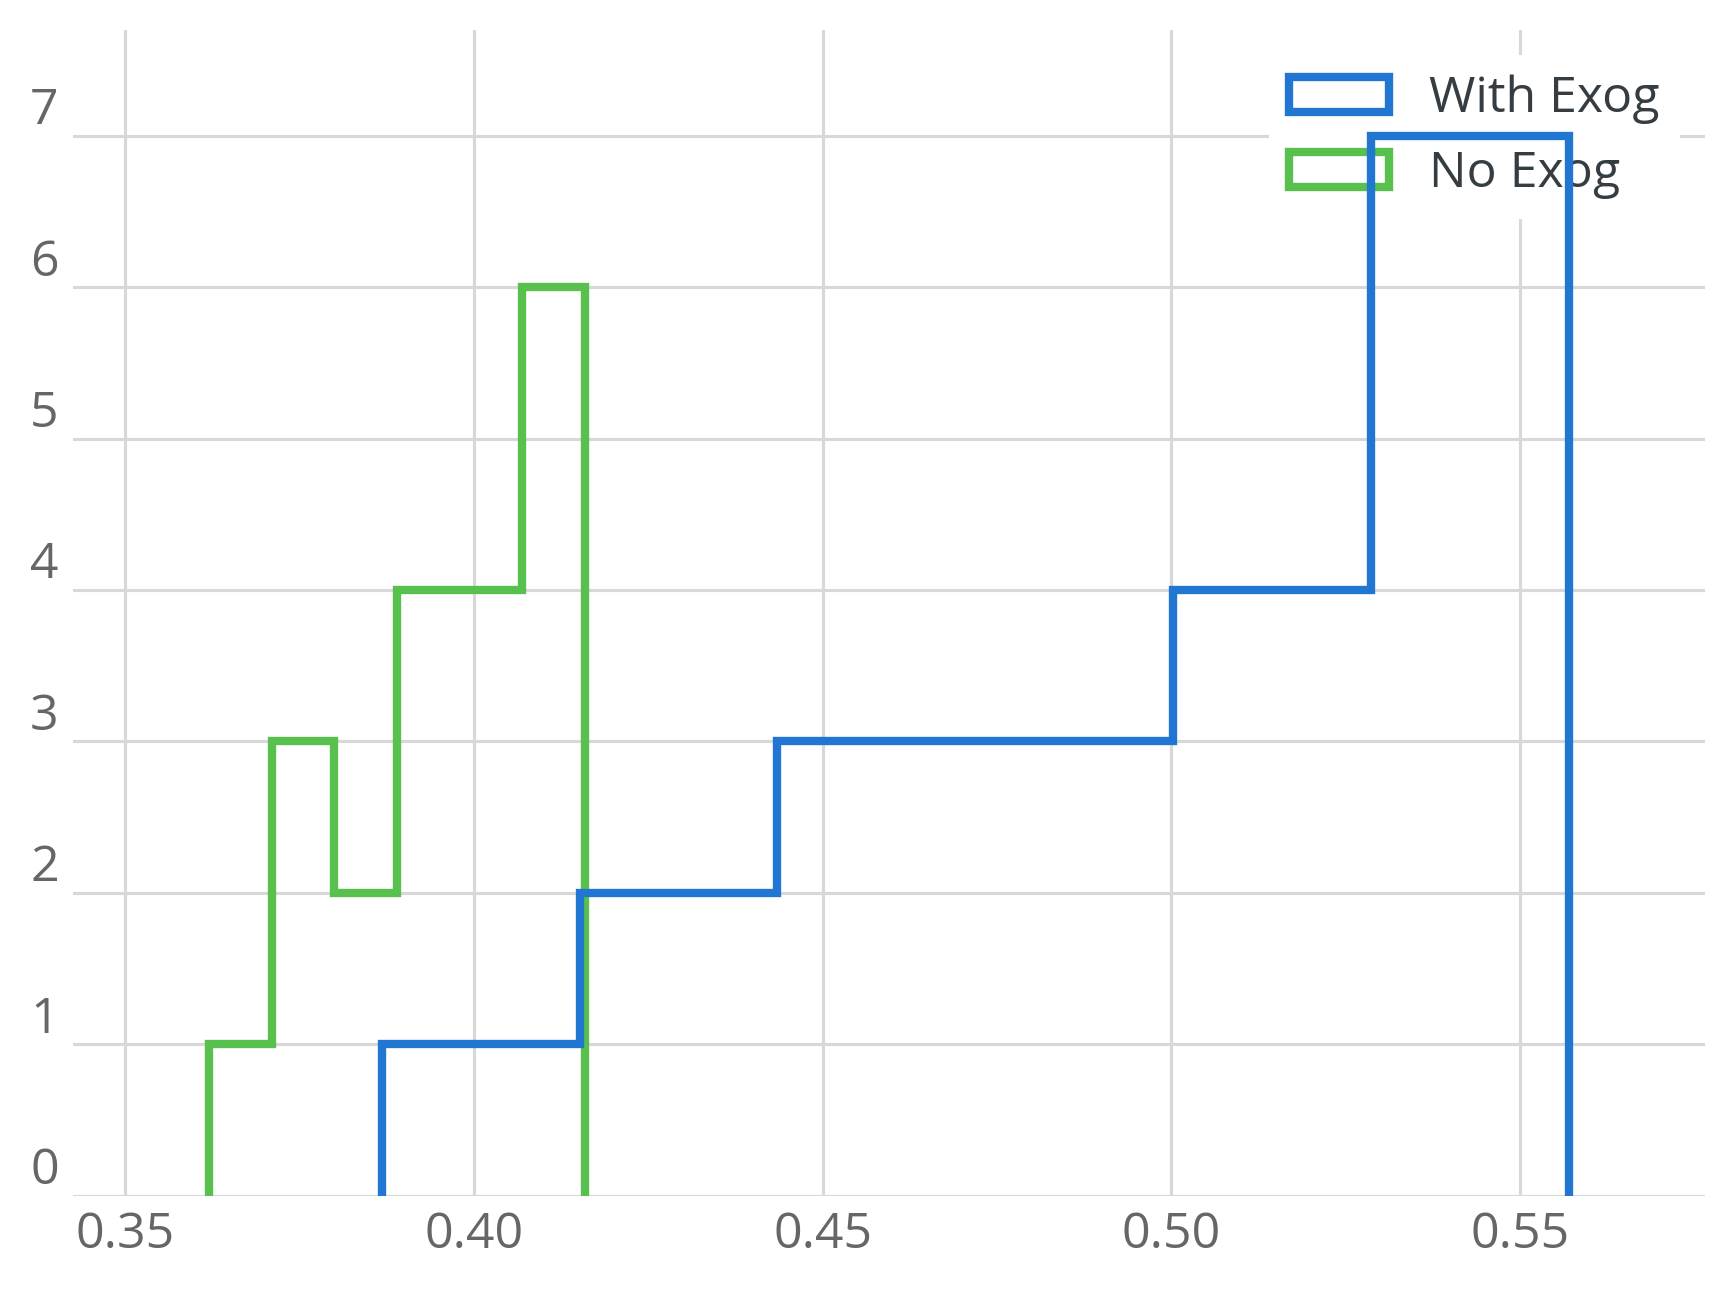

In [33]:
with plt.style.context(get_theme()):

    fig, ax = plt.subplots()

    ax.hist(
        [d["target_mape"] for d in fits_with_exog[:20] if d["target_mape"] < 1],
        bins="auto",
        histtype="step",
        label="With Exog",
        zorder=10,
        lw=2,
    )
    ax.hist(
        [d["target_mape"] for d in fits_no_exog[:20] if d["target_mape"] < 1],
        bins="auto",
        histtype="step",
        label="No Exog",
        lw=2,
    )
    ax.legend()

### Run the VAR with the best-fit params

In [34]:
best_params = all_fits[0]
best_params

{'mape_splits': [NetIncomeBase         0.650269
  ConsumerConfidence    0.009864
  dtype: float64,
  NetIncomeBase         0.215970
  ConsumerConfidence    0.021096
  dtype: float64,
  NetIncomeBase         0.219789
  ConsumerConfidence    0.011511
  dtype: float64],
 'mape': NetIncomeBase         0.362009
 ConsumerConfidence    0.014157
 dtype: float64,
 'order': 2,
 'endog_cols': ['NetIncomeBase', 'ConsumerConfidence'],
 'exog_cols': [],
 'model_quarters': True,
 'model_covid': False,
 'max_fit_date': '2022-06-30',
 'target_mape': 0.3620093305726921}

In [35]:
result, forecast = fit_var_model(
    unscaled_features,
    preprocess,
    plan_start_year=plan_start_year,
    max_fit_date=best_params["max_fit_date"],
    cbo_data=cbo_data,
    endog_cols=best_params["endog_cols"],
    order=best_params["order"],
    exog_cols=best_params["exog_cols"],
    model_quarters=best_params["model_quarters"],
)
print(result.aic)

-13.261141584149321


In [36]:
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 08, Jul, 2022
Time:                     12:00:46
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -12.8443
Nobs:                     100.000    HQIC:                  -13.0924
Log likelihood:           395.269    FPE:                1.74204e-06
AIC:                     -13.2611    Det(Omega_mle):     1.49351e-06
--------------------------------------------------------------------
Results for equation D.NetIncomeBase
                                coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                              0.025538         0.046032            0.555           0.579
month_4                            0.082739         0.064177            1.289           0.19

2022-07-08 12:00:47.016 | INFO     | fyp_analysis.pipelines.modeling.predict.viz:plot_forecast_results:62 - Year-over-Year Change
2022-07-08 12:00:47.019 | INFO     | fyp_analysis.pipelines.modeling.predict.viz:plot_forecast_results:63 - 2021    0.013775
2022    0.171083
2023    0.031165
2024    0.026589
2025    0.025855
2026    0.025203
2027    0.024584
Name: NetIncomeBase, dtype: float64


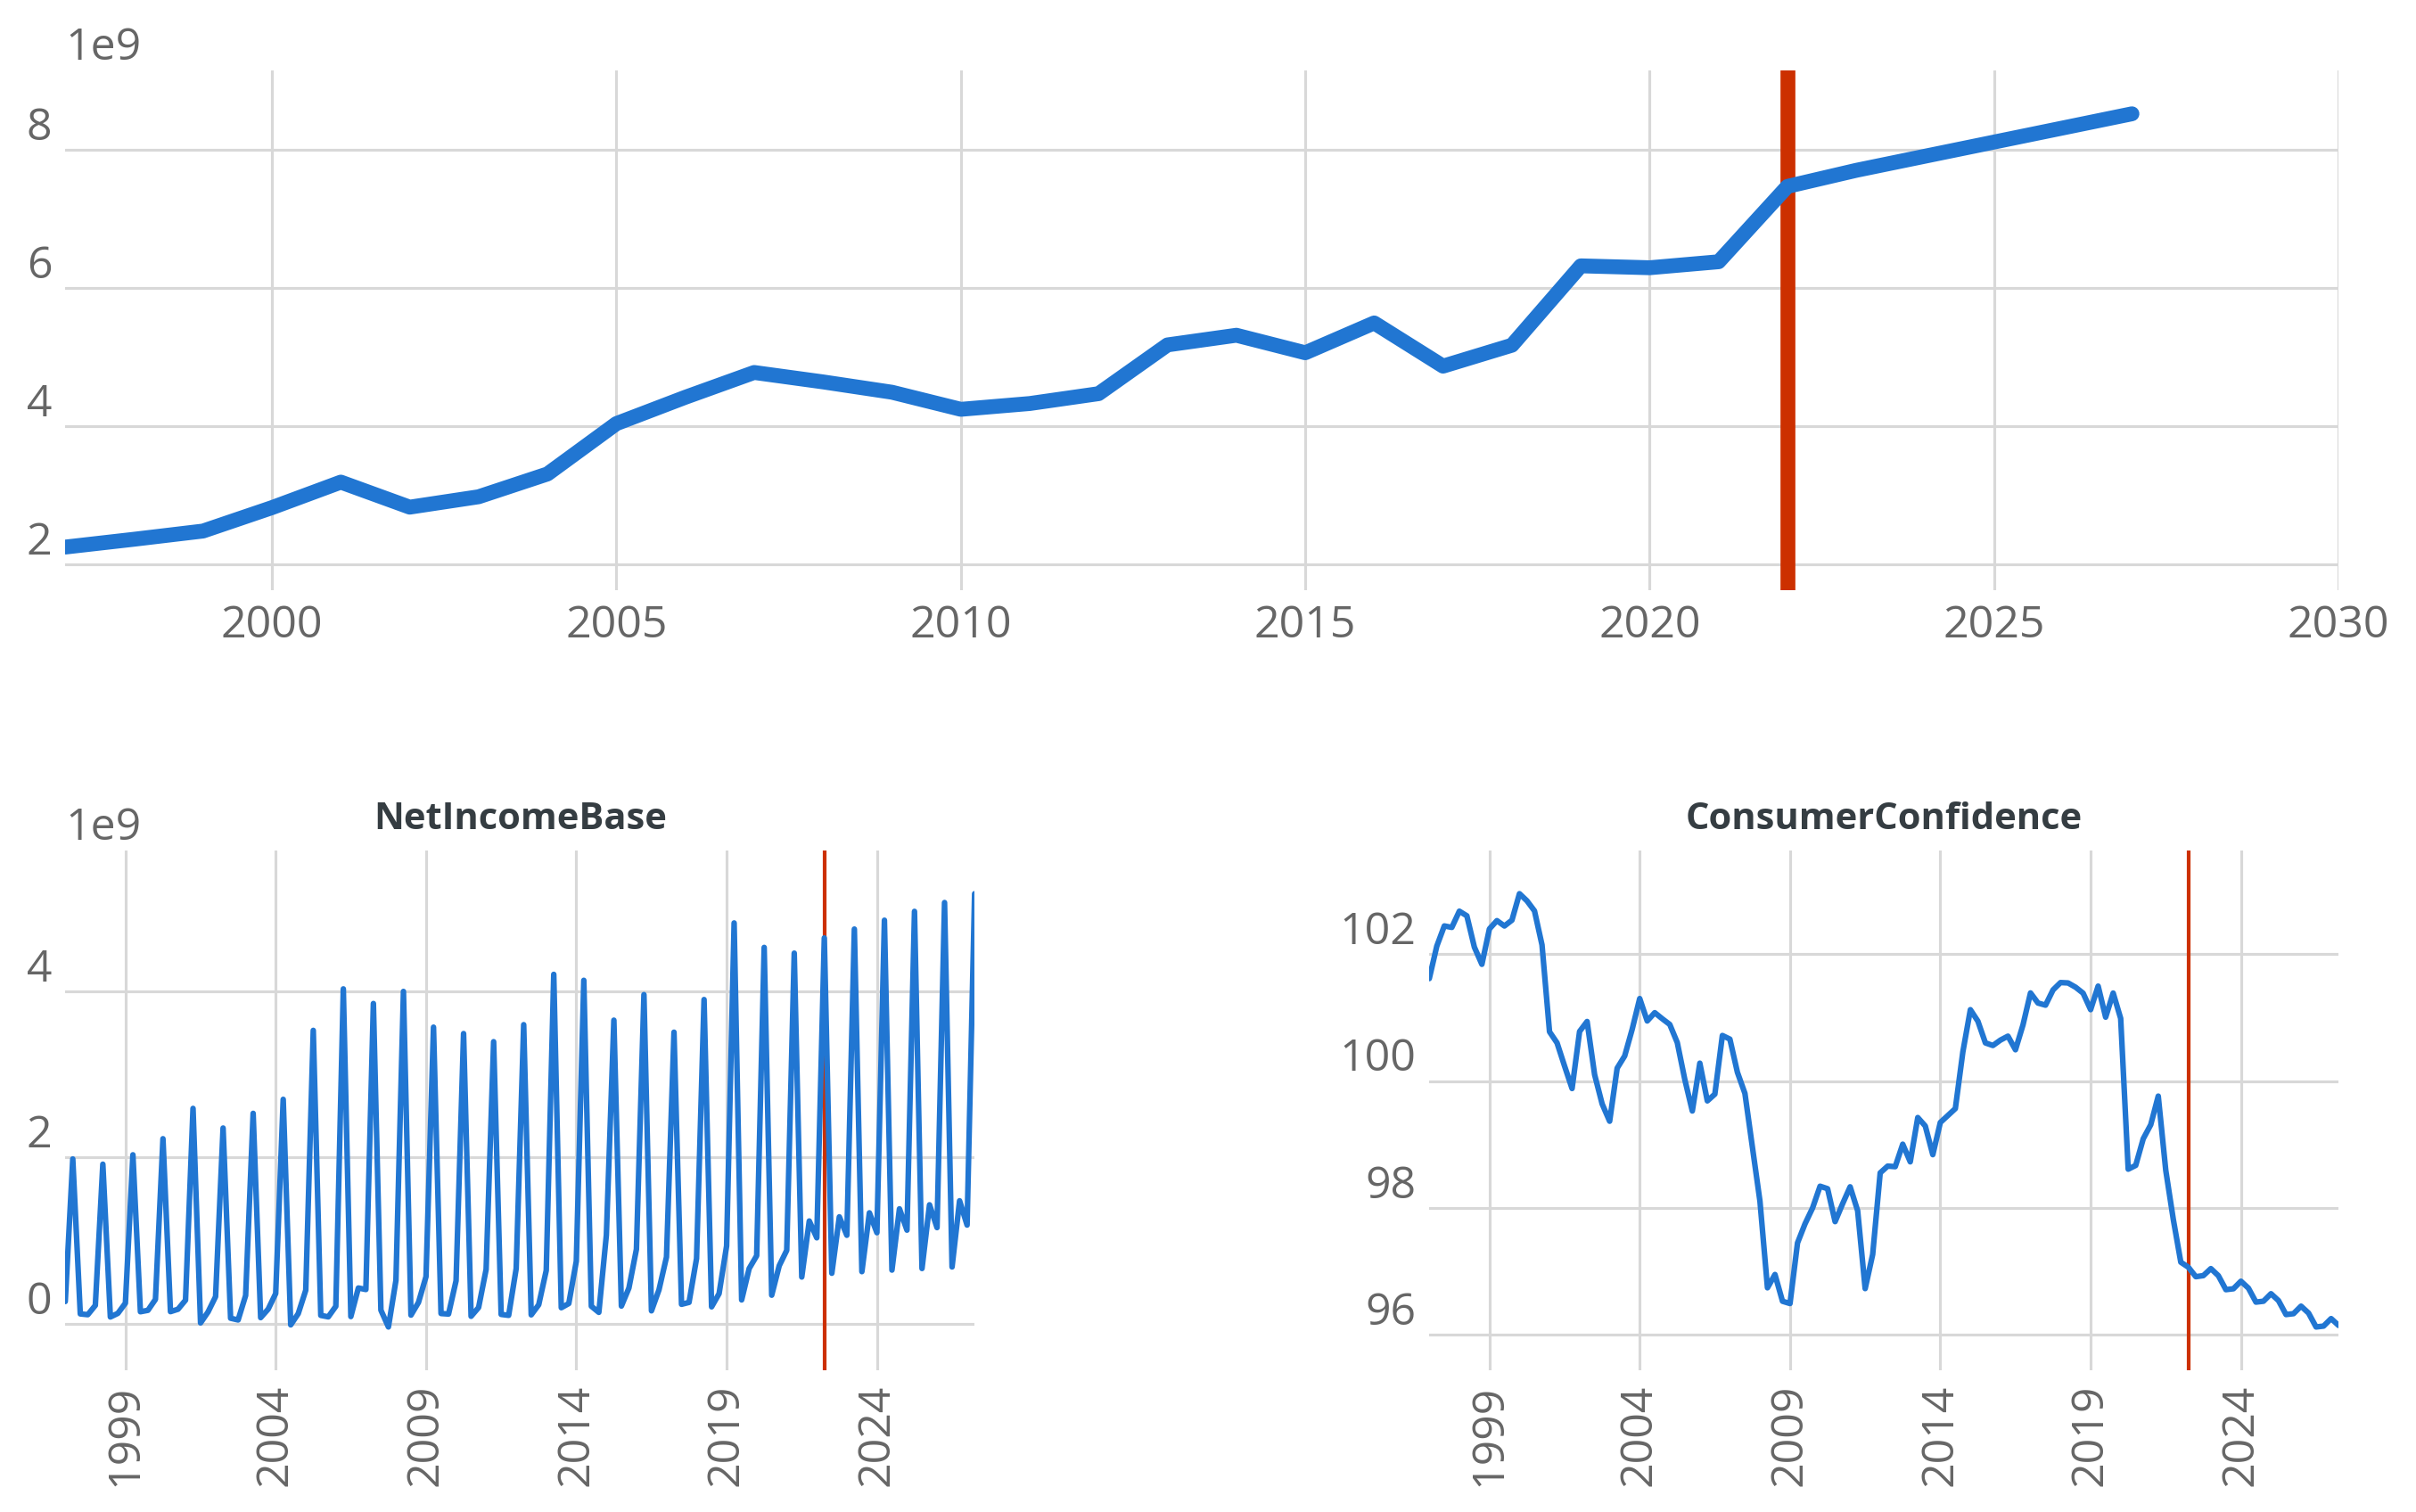

In [37]:
fig = plot_forecast_results(forecast, TAX_BASE_COLUMN);

In [38]:
[d['target_mape'] for d in all_fits[:10]]

[0.3620093305726921,
 0.37620968490506335,
 0.3764962900550453,
 0.37980117635390165,
 0.3827949013040663,
 0.38673469714055114,
 0.3883540706028662,
 0.3902588880681564,
 0.3911326553380932,
 0.3930012533124479]

In [39]:
TOP = 1

all_forecasts = get_forecasts_from_fits(
    unscaled_features,
    preprocess,
    all_fits,
    TAX_BASE_COLUMN,
    plan_start_year,
    cbo_data,
    max_fits=TOP,
)

### Save Best-fit Parameters

In [40]:
DATA.save("net_income_fit_params", all_fits[:TOP])

2022-07-08 12:00:51,395 - kedro.io.data_catalog - INFO - Saving data to `net_income_fit_params` (PickleDataSet)...
